In [1]:
import torch
# import tenseal as ts
import pandas as pd
import time

from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import pickle
import seaborn as sns
from openfhe import *
from tqdm import tqdm
import openfhe
from openfhe import PKESchemeFeature

Setul de date este luat din kaggle: https://www.kaggle.com/datasets/mahatiratusher/stroke-risk-prediction-dataset-v2/data si este procesat in notebook-ul data/process_data.ipynb pentru usurinta.

Codul se poate rula integral prin optiunea "Run All" a notebook-ului

In [2]:
def load_data(path):
    saved_data = torch.load(path,weights_only=True)
    x_train = saved_data['train_data']
    x_test = saved_data['test_data']
    y_train = saved_data['train_labels']
    y_test = saved_data['test_labels']
    print("############# Data summary #############")
    print(f"x_train has shape: {x_train.shape}")
    print(f"y_train has shape: {y_train.shape}")
    print(f"x_test has shape: {x_test.shape}")
    print(f"y_test has shape: {y_test.shape}")
    print("#######################################")
    return x_train,x_test,y_train,y_test

In [3]:
def normalize_data(x_train,x_test,y_train,y_test):
    scaler = StandardScaler()
    x_train = torch.tensor(scaler.fit_transform(x_train), dtype=torch.float32)
    x_test= torch.tensor(scaler.transform(x_test), dtype=torch.float32)
    print(x_train.shape)
    print(x_test.shape)
    y_train = torch.tensor(scaler.fit_transform(y_train), dtype=torch.float32)
    y_test = torch.tensor(scaler.transform(y_test), dtype=torch.float32)
    return x_train,x_test,y_train,y_test


In [4]:
x_train,x_test,y_train,y_test = load_data('../../data/date_liniar_regression.pth')
x_train,x_test,y_train,y_test = normalize_data(x_train,x_test,y_train,y_test)
x_train,x_test,y_train,y_test= x_train[:500,:8],x_test[:200, :8],y_train[:500,:8],y_test[:200, :8]
# print(x_train)

############# Data summary #############
x_train has shape: torch.Size([24500, 16])
y_train has shape: torch.Size([24500, 1])
x_test has shape: torch.Size([10500, 16])
y_test has shape: torch.Size([10500, 1])
#######################################
torch.Size([24500, 16])
torch.Size([10500, 16])


In [5]:
class LinearRegressionEncrypted:
    def __init__(self, n_features, learning_rate=1e-2, weight_decay=0.01):
        self.bound = np.sqrt(3/n_features)
        self.weight = [0.01] * n_features
        # self.weight = np.random.uniform(-self.bound, self.bound, size=n_features).tolist()
        self.bias = np.zeros(n_features).tolist()
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self._delta_w = 0
        self._delta_b = 0


    def forward_on_encrypted_data(self, enc_x):
        output = []
        for x in enc_x:
            enc_sum = cc.EvalInnerProduct(x, self.weight,8)
            enc_pred = cc.EvalAdd(enc_sum, self.bias)
            output.append(enc_pred)
        return output

   
    def backward(self, enc_x, enc_out, enc_y):
        batch_size = len(enc_x)
        half = 2/batch_size
        delta_y = [cc.EvalSub(out , y) for out, y in zip(enc_out, enc_y)]
        delta_w = [cc.EvalMultAndRelinearize(x , dy) for dy, x in zip(delta_y, enc_x)]
        self._delta_w = cc.EvalAddManyInPlace(delta_w)
        self._delta_w = cc.EvalMult(self._delta_w, half)
        self._delta_b = cc.EvalAddManyInPlace(delta_y)
        self._delta_b = cc.EvalMult(self._delta_b, half)
       

    def update_parameters(self):
        if self._delta_w == 0:
            raise RuntimeError("Trebuie sa treci prin functia forword macar o data")
        self._delta_w = cc.EvalMult(self._delta_w, self.learning_rate)
        prod = cc.EvalMult(self.weight_decay,  self.weight)
        self._delta_w = cc.EvalAdd(self._delta_w, prod) 
        self.weight = cc.EvalSub(self.weight, self._delta_w)
        prod = cc.EvalMult(self._delta_b, self.learning_rate)
        self.bias = cc.EvalSub(self.bias,prod) 

        # decr_w= cc.Decrypt(self.weight, keys.secretKey)
        # decr_w = decr_w.GetRealPackedValue()
        # decr_b = cc.Decrypt(self.bias, keys.secretKey)
        # decr_b = decr_b.GetRealPackedValue()
    
        self._delta_w = 0
        self._delta_b = 0
    def encrypt(self):
        self.weight = cc.MakeCKKSPackedPlaintext(self.weight)
        self.weight = cc.Encrypt(keys.publicKey, self.weight )
        self.bias = cc.MakeCKKSPackedPlaintext(self.bias)
        self.bias= cc.Encrypt(keys.publicKey, self.bias)
        
    def reduce_noise(self):
        self.weight.SetSlots(8)
        self.weight = cc.EvalBootstrap(self.weight, 2)
        self.bias.SetSlots(8)
        self.bias= cc.EvalBootstrap(self.bias, 2)
       

In [6]:
scaling_mod_size = 59
first_mod = 60
cc_params = openfhe.CCParamsCKKSRNS()
sk_dist = openfhe.UNIFORM_TERNARY
level_budget = [ 2, 2 ]
bsgs_dim =  [0, 0]
levels_before_bootstrap = 16
approx_bootstrap_depth = 8
mult_depth = levels_before_bootstrap + openfhe.FHECKKSRNS.GetBootstrapDepth(
    approx_bootstrap_depth, level_budget, sk_dist
)
print(f"Bootstrap final depth: {mult_depth}")
cc_params.SetSecretKeyDist(sk_dist)


cc_params.SetMultiplicativeDepth(mult_depth)
cc_params.SetScalingModSize(scaling_mod_size)
cc_params.SetBatchSize(8)
cc_params.SetSecurityLevel(openfhe.HEStd_NotSet)
cc_params.SetRingDim(4096)
cc_params.SetScalingTechnique(openfhe.FIXEDAUTO)
cc_params.SetKeySwitchTechnique(openfhe.HYBRID)
cc_params.SetNumLargeDigits(0)
cc_params.SetFirstModSize(first_mod)
cc_params.SetMaxRelinSkDeg(1)

cc = openfhe.GenCryptoContext(cc_params)
cc.Enable(openfhe.PKESchemeFeature.PKE)
cc.Enable(openfhe.PKESchemeFeature.LEVELEDSHE)
cc.Enable(openfhe.PKESchemeFeature.ADVANCEDSHE)
cc.Enable(openfhe.PKESchemeFeature.FHE)
keys: openfhe.KeyPair = cc.KeyGen()
cc.EvalMultKeyGen(keys.secretKey)
cc.EvalSumKeyGen(keys.secretKey)
num_slots_boot= 8
cc.EvalBootstrapSetup(level_budget, bsgs_dim, num_slots_boot)
cc.EvalBootstrapKeyGen(keys.secretKey, num_slots_boot)




Bootstrap final depth: 33


In [7]:
#libraria openfhe lucreaza cu doar cu liste, datele mele sunt torch tensors, deci trebuie convertite
print(x_train.shape)
x_train_list = x_train.tolist() 
print(x_train_list[:2])
print(type(x_train_list[0]))

print(y_train.shape)
y_train_list = y_train.tolist() 
print(y_train_list[:2])
print(type(y_train_list[0]))


print(x_test.shape)
x_test_list = x_test.tolist() 
print(x_test_list[:2])
print(type(x_test_list[0]))


torch.Size([500, 8])
[[0.38178399205207825, 0.9948703050613403, -0.4117799401283264, -0.5782929062843323, -0.3283218741416931, -0.48778727650642395, -0.5707517862319946, -0.4851568639278412], [0.38178399205207825, 0.9948703050613403, -0.4117799401283264, -0.5782929062843323, 3.0457913875579834, -0.48778727650642395, 1.7520751953125, 2.0611891746520996]]
<class 'list'>
torch.Size([500, 1])
[[-0.6384840607643127], [1.2037829160690308]]
<class 'list'>
torch.Size([200, 8])
[[-0.4856494069099426, -1.00515615940094, -0.4117799401283264, 1.7292275428771973, -0.3283218741416931, -0.48778727650642395, -0.5707517862319946, -0.4851568639278412], [1.2492173910140991, 0.9948703050613403, -0.4117799401283264, 1.7292275428771973, 3.0457913875579834, 2.0500738620758057, 1.7520751953125, 2.0611891746520996]]
<class 'list'>


In [8]:
def encrypt_vector(lista):
    enc_list=[]
    for x_t_l in tqdm(lista, desc="data encryption"):
        x_test_encoded = cc.MakeCKKSPackedPlaintext(x_t_l)
        enc_x = cc.Encrypt(keys.publicKey, x_test_encoded)
        enc_list.append(enc_x)
    return enc_list

In [9]:
t_start = time.perf_counter()
enc_x_train = encrypt_vector(x_train_list)
t_end = time.perf_counter()
print(f"encryption took: {t_end-t_start}")

data encryption: 100%|██████████| 500/500 [00:11<00:00, 42.90it/s]

encryption took: 11.661923369000007


In [10]:
t_start = time.perf_counter()
enc_x_test = encrypt_vector(x_test_list)
t_end = time.perf_counter()
print(f"encryption took: {t_end-t_start}")

data encryption:   0%|          | 0/200 [00:00<?, ?it/s]

data encryption: 100%|██████████| 200/200 [00:04<00:00, 41.94it/s]

encryption took: 4.771566970000009


In [11]:
#etichetele fiind vectori de dimensiune 1 trebuie facut broadcast la valoarea de pe pozitia 0, marind vectorul
#la unul de dimensiune 16, deoarce biblioteca lucreza cu vectori de dimenesniuni : batchSize = len(x_test[1]) #16
def encrypt_vector_y(lista):
    enc_list=[]
    for x_t_l in tqdm(lista, desc="data encryption"):
        x_test_encoded = cc.MakeCKKSPackedPlaintext(x_t_l*8)
        enc_x = cc.Encrypt(keys.publicKey, x_test_encoded)
        enc_list.append(enc_x)
    return enc_list

In [12]:
t_start = time.perf_counter()
enc_y_train = encrypt_vector_y(y_train_list)
t_end = time.perf_counter()
print(f"encryption took: {t_end-t_start}")

data encryption: 100%|██████████| 500/500 [00:13<00:00, 38.16it/s]

encryption took: 13.111213561


In [20]:
print(cc.Decrypt(enc_y_train[0],keys.secretKey))
#se vede aici ce fel de vector trebuie sa avem pentru etichete

(-0.638484, -0.638484, -0.638484, -0.638484,  ... ); Estimated precision: 51 bits



In [21]:
def save_model(model,file_path):
    pickle.dump(model, open(file_path, "wb"))


In [13]:
def forward_test_clear(weight, bias, x_test):
    dec_w = cc.Decrypt(weight, keys.secretKey)
    real_w = dec_w.GetRealPackedValue()
    dec_b = cc.Decrypt(bias, keys.secretKey)
    real_b = dec_b.GetRealPackedValue()
    w = torch.tensor(real_w)
    b = torch.tensor(real_b)
    out = (x_test.matmul(w) + b[0]).reshape(-1, 1)
    return out

In [15]:
y = y_test.detach().numpy()

In [16]:
model = LinearRegressionEncrypted(x_train.shape[1])
batch_size = 200
t_start = time.perf_counter()
model.encrypt()
for epoch in tqdm(range(20),desc="epoch"):
    t_start_epoch = time.perf_counter()
    indices = np.random.permutation(len(enc_x_train))
    epoch_data = [enc_x_train[idx] for idx in indices]
    epoch_targets = [enc_y_train[idx] for idx in indices]


    for batch in range(0, len(epoch_data),batch_size):
        #deoarce weight-urile si bias-ul acumuleaza mult noise avem 2 optiuni:
        #-bootstraping (extrem de greoi)
        #sa criptam si decryptam weight-urile 
        if epoch>0:
            model.reduce_noise()
        batch_data = epoch_data[batch: batch+batch_size]
        batch_targets = epoch_targets[batch: batch+batch_size]

        batch_out = model.forward_on_encrypted_data(batch_data)
        model.backward(batch_data, batch_out, batch_targets)
        model.update_parameters()
    
    pred = forward_test_clear(model.weight, model.bias ,x_test)
    t_end = time.perf_counter()

    pred = pred.detach().numpy()
    r2 = r2_score(y, pred)
    print(f"R^2 Score = {r2:.4f}")
    mse =  mean_squared_error(y, pred)
    print(f"MSE = {mse:.4f}")
t_end = time.perf_counter()
print(f"Antrenarea modelului pe date criptate a durat: {t_end-t_start} secunde")
# save_model(model,'li_r_trained_on_clear_data.pkl')


epoch:   5%|▌         | 1/20 [02:16<43:10, 136.32s/it]

R^2 Score = 0.2075
MSE = 0.8167


epoch:  10%|█         | 2/20 [03:52<33:45, 112.53s/it]

R^2 Score = 0.3295
MSE = 0.6910


epoch:  15%|█▌        | 3/20 [05:43<31:41, 111.86s/it]

R^2 Score = 0.4236
MSE = 0.5941


epoch:  20%|██        | 4/20 [07:27<28:59, 108.70s/it]

R^2 Score = 0.4965
MSE = 0.5189


epoch:  25%|██▌       | 5/20 [09:10<26:40, 106.71s/it]

R^2 Score = 0.5561
MSE = 0.4575


epoch:  30%|███       | 6/20 [10:50<24:24, 104.60s/it]

R^2 Score = 0.6034
MSE = 0.4087


epoch:  35%|███▌      | 7/20 [12:27<22:05, 101.98s/it]

R^2 Score = 0.6423
MSE = 0.3686


epoch:  40%|████      | 8/20 [14:03<20:01, 100.16s/it]

R^2 Score = 0.6731
MSE = 0.3369


epoch:  45%|████▌     | 9/20 [15:34<17:49, 97.25s/it] 

R^2 Score = 0.6982
MSE = 0.3111


epoch:  50%|█████     | 10/20 [16:55<15:21, 92.14s/it]

R^2 Score = 0.7182
MSE = 0.2905


epoch:  55%|█████▌    | 11/20 [18:16<13:20, 88.95s/it]

R^2 Score = 0.7344
MSE = 0.2738


epoch:  60%|██████    | 12/20 [19:34<11:24, 85.54s/it]

R^2 Score = 0.7480
MSE = 0.2597


epoch:  65%|██████▌   | 13/20 [21:00<09:58, 85.51s/it]

R^2 Score = 0.7594
MSE = 0.2480


epoch:  70%|███████   | 14/20 [22:27<08:36, 86.14s/it]

R^2 Score = 0.7684
MSE = 0.2387


epoch:  75%|███████▌  | 15/20 [24:10<07:35, 91.01s/it]

R^2 Score = 0.7758
MSE = 0.2311


epoch:  80%|████████  | 16/20 [25:55<06:21, 95.31s/it]

R^2 Score = 0.7821
MSE = 0.2246


epoch:  85%|████████▌ | 17/20 [27:39<04:54, 98.02s/it]

R^2 Score = 0.7876
MSE = 0.2189


epoch:  90%|█████████ | 18/20 [29:23<03:19, 99.90s/it]

R^2 Score = 0.7919
MSE = 0.2145


epoch:  95%|█████████▌| 19/20 [31:01<01:39, 99.19s/it]

R^2 Score = 0.7954
MSE = 0.2108


epoch: 100%|██████████| 20/20 [32:39<00:00, 97.95s/it]

R^2 Score = 0.7983
MSE = 0.2079
Antrenarea modelului pe date criptate a durat: 1959.10684853 secunde


diferenta de acuratete este de la faptul ca am antrenat pe mai putine date ca sa incapa in memorie bootstraping-ul

weight-urile si bias-ul vin criptate

In [16]:
model.weight

In [17]:
def metrics_on_clear_data(model, x, y):
    t_start = time.perf_counter()
    pred = forward_test_clear(model.weight, model.bias,x)
    t_end = time.perf_counter()
    print(f"Predictiile pe testul de date necriptate au durat:{(t_end - t_start):.20f} secunde")

    r2 = r2_score(y, pred)
    print(f"R^2 Score = {r2:.4f}")
    mse =  mean_squared_error(y, pred)
    print(f"MSE = {mse:.4f}")

    plt.figure(figsize=(10, 6))
    plt.scatter(y, pred, alpha=0.5, color='darkred', label='Predicții vs. Valori Reale')
    plt.plot([min(y), max(y)], [min(y), max(y)], color='blue', linestyle='--', label='Predicții perfecte')
    plt.xlabel('Valori Reale', fontsize=12)
    plt.ylabel('Predicții', fontsize=12)
    plt.title('Model antrenat pe date criptate-Preziceri pe date clare', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(title=f'$R^2 = {r2:.4f}$\nMSE = {mse:.4f}', title_fontsize=12)
    plt.savefig("../../plots/liniar_regression/li_r_trained_on_encrypted_data_predictions_on_clear_data_bootstrap.png")
    plt.show()
    return r2,mse

Predictiile pe testul de date necriptate au durat:0.02039135900031396886 secunde
R^2 Score = 0.7983
MSE = 0.2079


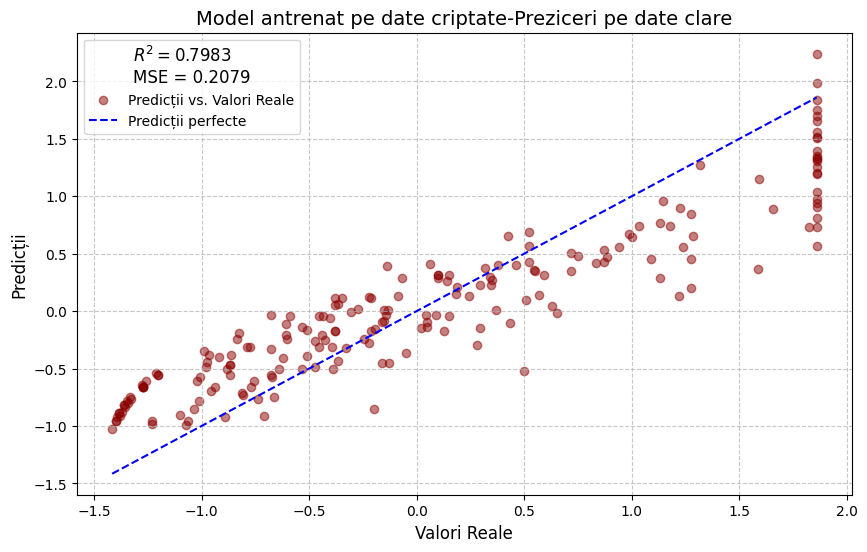

In [18]:
r2_clear,mse= metrics_on_clear_data(model,x_test, y_test)

In [19]:
def feature_importance(model, feature_names):
    dec_w = cc.Decrypt(model.weight, keys.secretKey)
    weights = dec_w.GetRealPackedValue()
    print(weights)

    weights = np.abs(weights)
    weights = weights / np.sum(weights)

    sorted_indices = np.argsort(weights)
    feature_names_sorted = [feature_names[i] for i in sorted_indices]
    weights_sorted = weights[sorted_indices]

    plt.figure(figsize=(16, 6))
    sns.barplot(y=feature_names_sorted, x=weights_sorted, hue=feature_names_sorted, palette="Reds", orient="h", legend=False)

    plt.xlabel('Importanța caracteristicilor', fontsize=12)
    plt.ylabel('Caracteristici', fontsize=12)
    plt.title('Grafic de importanța caracteristicilor- model antrenat pe date criptate', fontsize=14)

    plt.grid(True, linestyle='--', alpha=0.7)
    plt.savefig("../../plots/liniar_regression/li_r_trained_on_encrypted_data_feature_importance_bootstrap.png")
    plt.show()



['Age', 'Gender', 'Chest Pain', 'High Blood Pressure', 'Irregular Heartbeat', 'Shortness Of Breath', 'Fatigue Weakness', 'Dizziness', 'Swelling Edema', 'Neck Jaw Pain', 'Excessive Sweating', 'Persistent Cough', 'Chest Discomfort', 'Cold Hands Feet', 'Snoring Sleep Apnea', 'Anxiety Doom']
[0.4390478066484998, -0.05099257695309465, 0.19546961114483208, 0.24592929189507204, 0.14730198545515655, 0.17015110145168286, 0.11740597393434403, 0.12178109467943923]


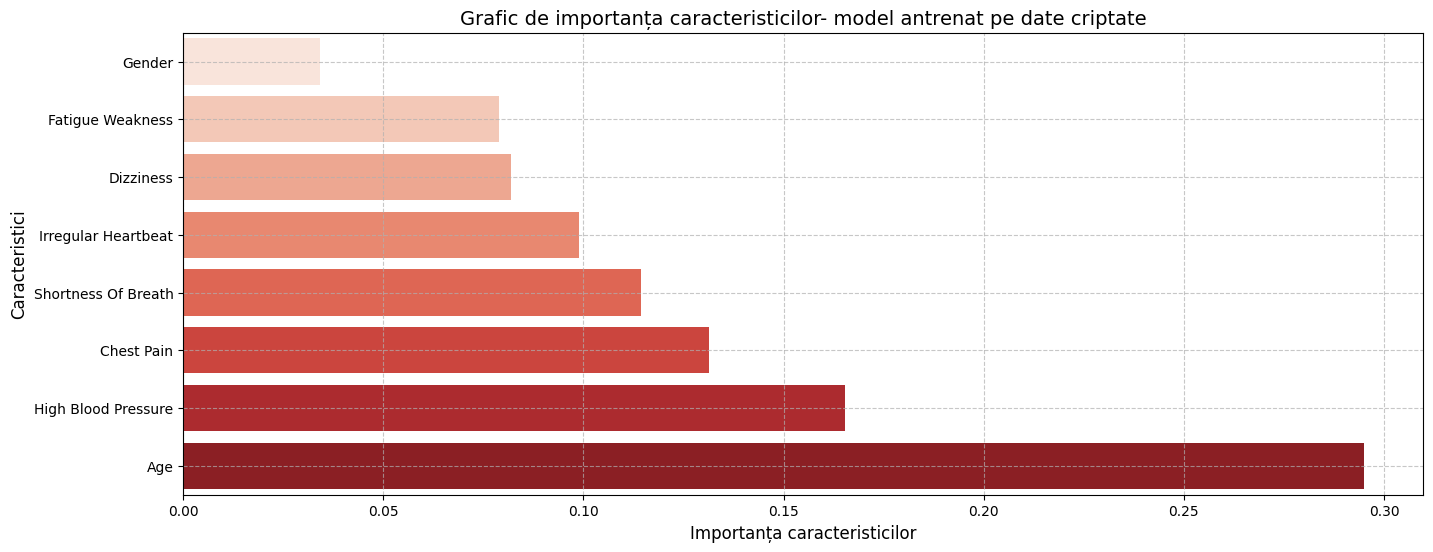

In [30]:
csv = pd.read_csv('../../data/stroke_risk_dataset.csv')
csv = csv.drop(columns=["stroke_risk_percentage", "at_risk", "nausea_vomiting"])
header = csv.columns.tolist()

formatted_features = [feat.replace('_', ' ').title() for feat in header]
print(formatted_features)
feature_importance(model,formatted_features) 

In [20]:
def metrics_on_encrypted_data(model, enc_x, y):
    #predictiile sunt se vor intoarce criptate
    t_start = time.perf_counter()
    # model.encrypt()
    model.reduce_noise()
    enc_list_pred = model.forward_on_encrypted_data(enc_x)
    # model.decrypt()
    t_end = time.perf_counter()
    print(f"Predictiile pe testul de date criptat au durat:{(t_end - t_start):.20f} secunde")
    # return enc_list_pred[0]
    #trebuie decriptate pentru a calcula metricile
    list_pred = []
    t_start = time.perf_counter()
    for enc_pred in enc_list_pred:
        decript = cc.Decrypt(enc_pred, keys.secretKey)
        # decript.SetLength(1)
        decoded_values = decript.GetCKKSPackedValue()
        # print(decoded_values)
        list_pred.append(decoded_values[0].real)
    t_end = time.perf_counter()
    print(f"Decriptarea predictiilor a durat:{(t_end - t_start):.20f} secunde")
    
    y = y.detach().numpy()
    r2 = r2_score(y, list_pred)
    print(f"R^2 Score = {r2:.4f}")
    mse =  mean_squared_error(y, list_pred)
    print(f"MSE = {mse:.4f}")

    plt.figure(figsize=(10, 6))
    plt.scatter(y, list_pred, alpha=0.5, color='darkred', label='Predictii vs. Valori Reale')
    plt.plot([min(y), max(y)], [min(y), max(y)], color='blue', linestyle='--', label='Predictii perfecte')
    plt.xlabel('Valori Reale', fontsize=12)
    plt.ylabel('Predictii', fontsize=12)
    plt.legend(title=f'$R^2 = {r2:.4f}$\nMSE = {mse:.4f}', title_fontsize=12)
    plt.title('Model antrenat pe date criptate-Preziceri pe date criptate', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.savefig("../../plots/liniar_regression/li_r_trained_on_encrypted_data_predictions_on_encrypted_data_bootstrap.png")
    plt.show()
    return r2

Predictiile pe testul de date criptat au durat:26.53204057199991439120 secunde
Decriptarea predictiilor a durat:2.12096091000012165750 secunde
R^2 Score = 0.7983
MSE = 0.2079


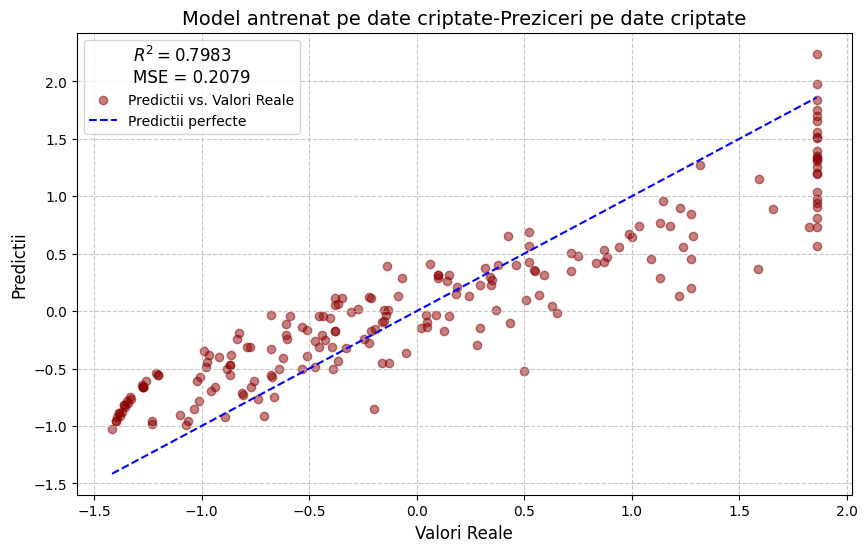

In [21]:
r2_enc = metrics_on_encrypted_data(model,enc_x_test,y_test)